In [1]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px

import category_encoders as ce

from sklearn import preprocessing

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
print('Количество дубликатов: {}'.format(df_train[df_train.duplicated()].shape[0]))
dupl_columns = list(df_train.columns)
df_train = df_train.drop_duplicates(subset=dupl_columns)
print('Количество дубликатов: {}'.format(df_train[df_train.duplicated()].shape[0]))

Количество дубликатов: 307
Количество дубликатов: 0


In [6]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([df_test, df_train], ignore_index=True).reset_index(drop=True)

In [7]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [8]:
display((hotels['lat'].isnull().value_counts(normalize=True) * 100).round())
display((hotels['lng'].isnull().value_counts(normalize=True) * 100).round())
# поскольку пустых значений не больше процента в каждом из указанных признаков применяем для долготы применяем mode, для широты - mean
hotels['lat'] = hotels['lat'].fillna(hotels['lat'].mean())
hotels['lng'] = hotels['lng'].fillna(hotels['lng'].mode()[0])

lat
False    99.0
True      1.0
Name: proportion, dtype: float64

lng
False    99.0
True      1.0
Name: proportion, dtype: float64

In [9]:
low_information_cols = [] 

#цикл по всем столбцам
for col in hotels.columns:
    #наибольшая относительная частота в признаке
    top_freq = hotels[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = hotels[col].nunique() / hotels[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.7:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.7:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
# По общим правилам при более 70 % уникальных значений в признаки его следует удалить, но, считаю, что признак важен для дальнейшей модели


positive_review: 80.05% уникальных значений
sample: 74.99% одинаковых значений


In [10]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [11]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['quarter'] = hotels['review_date'].dt.quarter

In [ ]:
hotels = hotels.drop(['review_date'], axis=1)

In [14]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

In [17]:
regex = '\d+' # регулярное выражение для нахождения чисел
hotels['days_since_review'] = hotels['days_since_review'].str.findall(regex).str.get(0)
hotels['days_since_review'] = hotels['days_since_review'].astype(int)
hotels.head(3)


,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,quarter
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,45.533137,9.171102,0,0.0,3
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,52.385649,4.834443,0,0.0,4
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,41.393192,2.161520,0,0.0,4


In [18]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()


slovar = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
slovar

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0         {'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...
1         {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...
2         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3         {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
4         {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
                                ...                        
515426    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
515427    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
515428    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
515429    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
515430    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: negative_review, Length: 515431, dtype: object

In [19]:
# Если говорить про датафрейм, то можно создать новый столбец на основе данного преобразования:

hotels['negative_score'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['negative_score_neg'] = hotels['negative_score'].apply(lambda x: x['neg'])

hotels['positive_score'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['positive_score_pos'] = hotels['positive_score'].apply(lambda x: x['pos'])

In [25]:
hotels = hotels.drop(['positive_score', 'all_review_score', 'negative_score', 'positive_review', 'negative_review'], axis=1)

In [26]:
hotels.head(3)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,quarter,negative_score_neg,positive_score_neg
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,45.533137,9.171102,0,0.0,3,0.129,0.329
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,52.385649,4.834443,0,0.0,4,0.216,0.621
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,3,351,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,41.393192,2.161520,0,0.0,4,0.000,0.740


In [27]:
# round(hotels_dupl['hotel_address'].corr(hotels_dupl['reviewer_score'], method='spearman'), 2)
# round(hotels_dupl['hotel_name'].corr(hotels_dupl['reviewer_score'], method='spearman'), 2)
hotels_cleaned = hotels.drop(['hotel_address', 'hotel_name'], axis=1)
hotels_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   reviewer_nationality                        515431 non-null  object 
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   tags                                        515431 non-null  object 
 8   days_since_review                           515431 non-null  int64  
 9   lat                                         515431 non-null  float64
 

In [28]:
top_nationality = hotels_cleaned['reviewer_nationality'].value_counts().nlargest(20)
hotels_cleaned['popular_nationality'] = hotels_cleaned['reviewer_nationality'].apply(lambda x: x if x in top_nationality else 'other')
hotels_nat_dummies = pd.get_dummies(hotels_cleaned, columns=['popular_nationality'], dtype='int')

In [29]:
hotels_nat_dummies.head(2)

,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,...,popular_nationality_ Russia,popular_nationality_ Saudi Arabia,popular_nationality_ South Africa,popular_nationality_ Spain,popular_nationality_ Switzerland,popular_nationality_ Turkey,popular_nationality_ United Arab Emirates,popular_nationality_ United Kingdom,popular_nationality_ United States of America,popular_nationality_other
0,904,8.1,United Kingdom,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,45.533137,...,0,0,0,0,0,0,0,1,0,0
1,612,8.6,Belgium,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,52.385649,...,0,0,0,0,0,0,0,0,0,0


In [30]:
hotels_nat_dummies = hotels_nat_dummies.drop('reviewer_nationality', axis=1)

In [31]:
hotels_nat_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 36 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   additional_number_of_scoring                    515431 non-null  int64  
 1   average_score                                   515431 non-null  float64
 2   review_total_negative_word_counts               515431 non-null  int64  
 3   total_number_of_reviews                         515431 non-null  int64  
 4   review_total_positive_word_counts               515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given      515431 non-null  int64  
 6   tags                                            515431 non-null  object 
 7   days_since_review                               515431 non-null  int64  
 8   lat                                             515431 non-null  float64
 9   lng                       

In [32]:
hotels_tag = hotels_nat_dummies.copy()

def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels_tag['tags_n'] = hotels_tag['tags'].apply(rev_func)
hotels_tag.info()

# hotels_tag = hotels_tag.explode('tags_n').reset_index(drop=True)
# len(hotels_tag['tags_n'].unique())
# hotels_tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 37 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   additional_number_of_scoring                    515431 non-null  int64  
 1   average_score                                   515431 non-null  float64
 2   review_total_negative_word_counts               515431 non-null  int64  
 3   total_number_of_reviews                         515431 non-null  int64  
 4   review_total_positive_word_counts               515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given      515431 non-null  int64  
 6   tags                                            515431 non-null  object 
 7   days_since_review                               515431 non-null  int64  
 8   lat                                             515431 non-null  float64
 9   lng                       

In [33]:
hotels_tag['leisure_trip'] = hotels_tag['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
hotels_tag['business_trip'] = hotels_tag['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)
hotels_tag['mobile device'] = hotels_tag['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)
hotels_tag['Couple'] = hotels_tag['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
hotels_tag['1 night'] = hotels_tag['tags'].apply(lambda x: 1 if 'Stayed 1 night' in x else 0)
hotels_tag['2 nights'] = hotels_tag['tags'].apply(lambda x: 1 if 'Stayed 2 nights' in x else 0)
hotels_tag['Solo traveler'] = hotels_tag['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
hotels_tag['3 nights'] = hotels_tag['tags'].apply(lambda x: 1 if 'Stayed 3 nights' in x else 0)
hotels_tag['Group'] = hotels_tag['tags'].apply(lambda x: 1 if 'Group' in x else 0)
hotels_tag['with children'] = hotels_tag['tags'].apply(lambda x: 1 if 'Family with young children' in x else 0)

In [34]:
hotels_tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 47 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   additional_number_of_scoring                    515431 non-null  int64  
 1   average_score                                   515431 non-null  float64
 2   review_total_negative_word_counts               515431 non-null  int64  
 3   total_number_of_reviews                         515431 non-null  int64  
 4   review_total_positive_word_counts               515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given      515431 non-null  int64  
 6   tags                                            515431 non-null  object 
 7   days_since_review                               515431 non-null  int64  
 8   lat                                             515431 non-null  float64
 9   lng                       

In [35]:
hotels_tag = hotels_tag.drop(['tags', 'tags_n'], axis=1)

array([[<Axes: title={'center': 'additional_number_of_scoring'}>,
        <Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'review_total_negative_word_counts'}>],
       [<Axes: title={'center': 'total_number_of_reviews'}>,
        <Axes: title={'center': 'review_total_positive_word_counts'}>,
        <Axes: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<Axes: title={'center': 'reviewer_score'}>,
        <Axes: title={'center': 'days_since_review'}>,
        <Axes: title={'center': 'lat'}>],
       [<Axes: title={'center': 'lng'}>,
        <Axes: title={'center': 'quarter'}>, <Axes: >]], dtype=object)

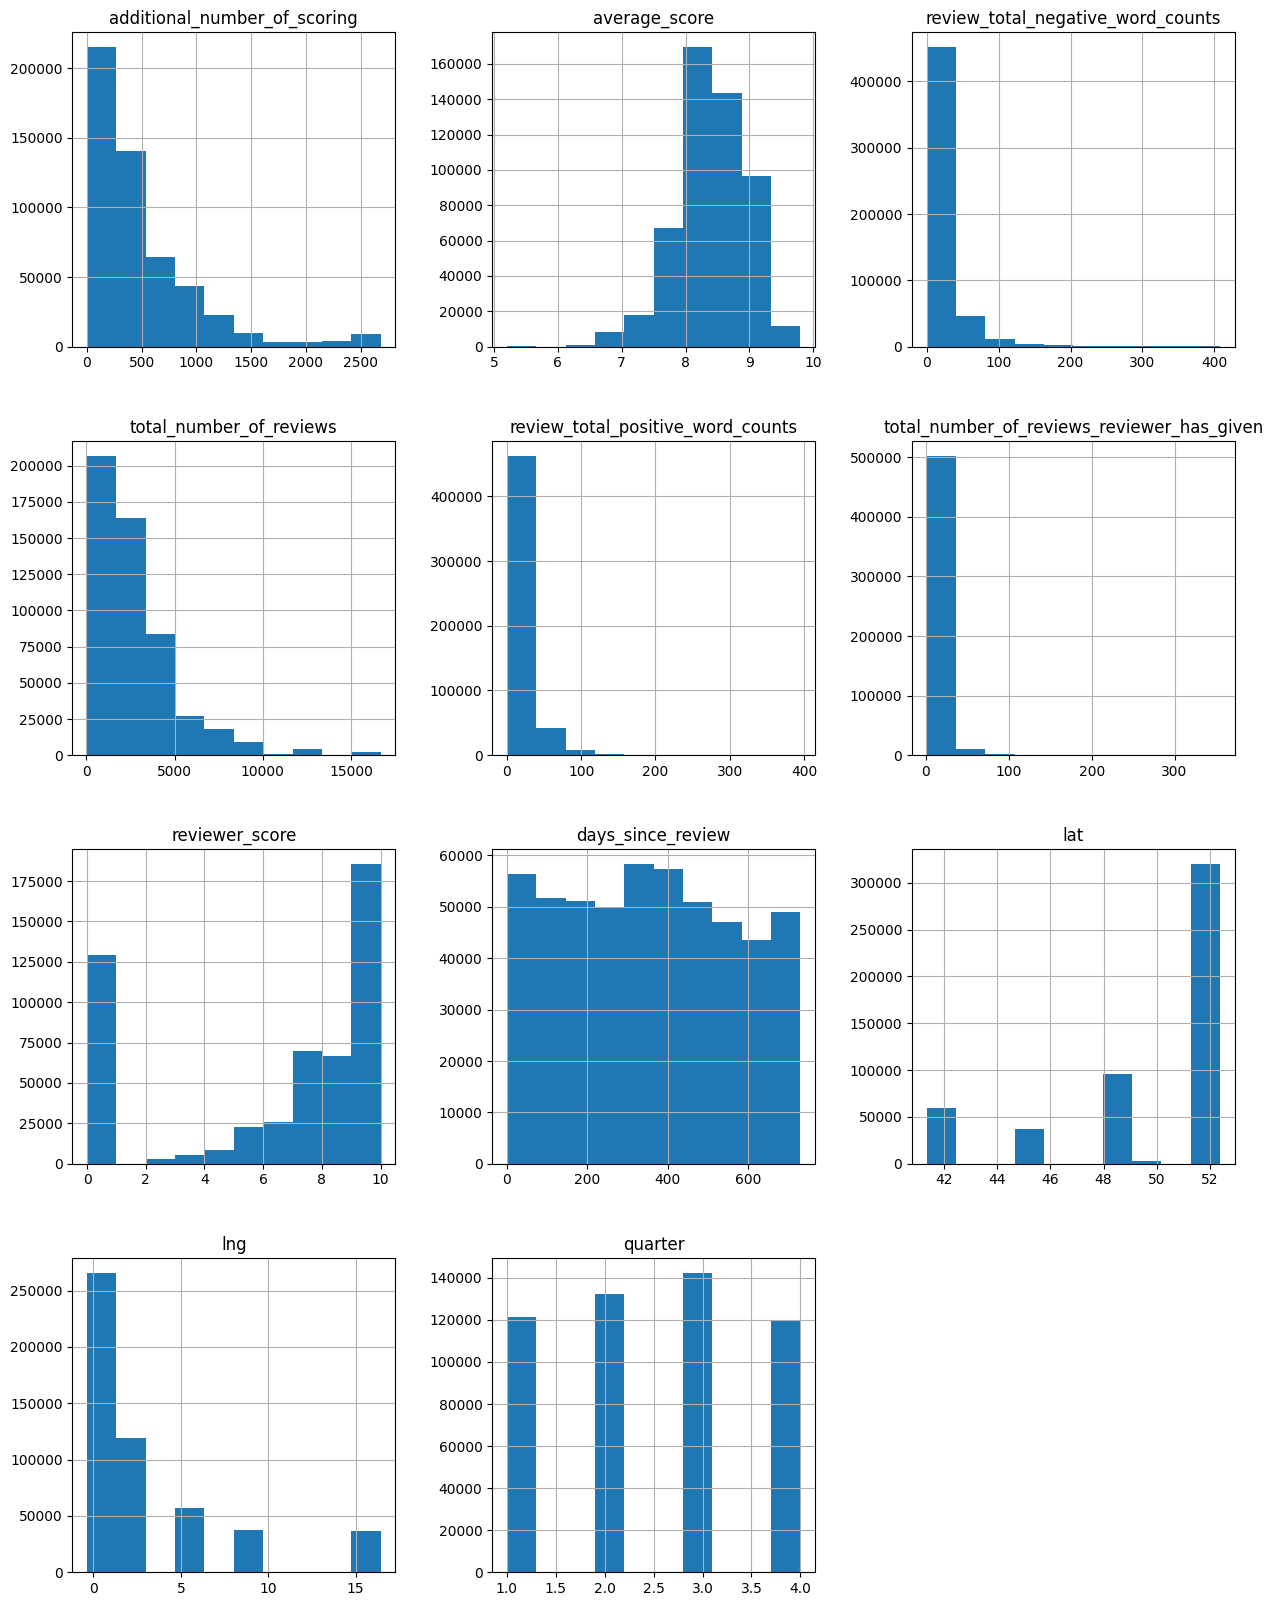

In [36]:
hotels_tag.hist(column=['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews',
                          'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 
'days_since_review', 'lat', 'lng', 'quarter'], figsize=(15, 20))

In [37]:
reviewer_col = hotels_tag['reviewer_score']
features_ml = hotels_tag.drop('reviewer_score', axis=1)
col_names = list(features_ml.columns)
col_names

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
hotels_r = r_scaler.fit_transform(features_ml)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_r = pd.DataFrame(features_ml, columns=col_names)

In [38]:
hotels_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 44 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   additional_number_of_scoring                    515431 non-null  int64  
 1   average_score                                   515431 non-null  float64
 2   review_total_negative_word_counts               515431 non-null  int64  
 3   total_number_of_reviews                         515431 non-null  int64  
 4   review_total_positive_word_counts               515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given      515431 non-null  int64  
 6   days_since_review                               515431 non-null  int64  
 7   lat                                             515431 non-null  float64
 8   lng                                             515431 non-null  float64
 9   sample                    

In [39]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(hotels_r, 30)

leisure_trip                          business_trip                                     0.904047
additional_number_of_scoring          total_number_of_reviews                           0.824904
business_trip                         Solo traveler                                     0.528530
leisure_trip                          Solo traveler                                     0.509046
Couple                                Solo traveler                                     0.505215
1 night                               2 nights                                          0.459301
popular_nationality_ United Kingdom   popular_nationality_other                         0.445652
Couple                                Group                                             0.372908
1 night                               3 nights                                          0.370443
Couple                                with children                                     0.358483
review_total_negative_word_cou

In [ ]:
hotels_r = hotels_r.drop('total_number_of_reviews', axis=1)

In [43]:
hotels_r['reviewer_score'] = reviewer_col
hotels_r.head(2)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,quarter,...,business_trip,mobile device,Couple,1 night,2 nights,Solo traveler,3 nights,Group,with children,reviewer_score
0,904,8.1,52,62,1,13,45.533137,9.171102,0,3,...,0,0,1,0,1,0,0,0,0,0.0
1,612,8.6,10,0,7,234,52.385649,4.834443,0,4,...,0,0,0,1,0,0,0,1,0,0.0


In [44]:
# Теперь выделим тестовую часть
train_data = hotels_r.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_r.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [45]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [46]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 43), (386496, 43), (386496, 42), (309196, 42), (77300, 42))

In [47]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [48]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [49]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [50]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8910068781494483


<Axes: >

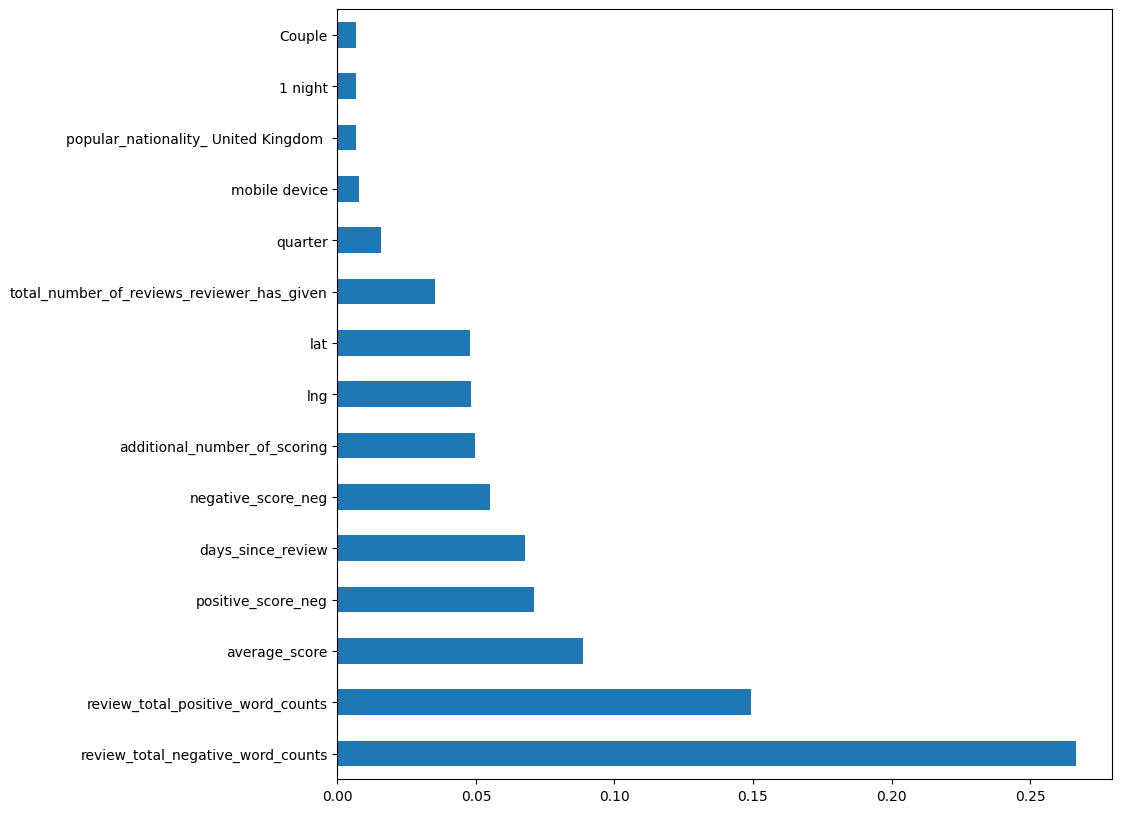

In [51]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [52]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,quarter,negative_score_neg,...,business_trip,mobile device,Couple,1 night,2 nights,Solo traveler,3 nights,Group,with children,reviewer_score
523,601,8.5,10,9,12,206,52.363889,4.881302,1,0.000,...,0,0,0,0,0,0,1,1,0,0.0
19621,757,8.7,37,14,1,126,52.357655,4.844576,1,0.248,...,0,0,1,0,0,0,0,0,0,0.0
112362,125,8.3,134,8,1,89,51.514033,-0.132065,2,0.068,...,0,1,1,0,1,0,0,0,0,0.0
79694,989,8.4,8,21,1,430,51.493847,-0.191758,2,0.000,...,0,1,1,1,0,0,0,0,0,0.0
85618,67,9.5,0,20,1,335,41.382700,2.179200,3,1.000,...,0,0,0,0,0,0,1,1,0,0.0
71794,68,7.8,0,8,8,80,51.522087,-0.108244,2,1.000,...,0,1,1,0,1,0,0,0,0,0.0
70873,32,8.2,0,28,1,505,48.871970,2.331601,1,1.000,...,0,1,1,1,0,0,0,0,0,0.0
63559,141,8.0,0,13,62,636,48.867320,2.365630,4,1.000,...,0,0,1,0,1,0,0,0,0,0.0
24780,834,9.1,8,14,18,676,52.370545,4.888644,3,0.000,...,0,1,0,1,0,1,0,0,0,0.0
71697,251,9.0,18,0,8,203,48.205633,16.377862,1,0.000,...,0,1,0,0,1,0,0,0,1,0.0


In [53]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [54]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [55]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [56]:
predict_submission

array([8.439, 6.866, 8.58 , ..., 7.983, 9.669, 7.644])

In [57]:
list(sample_submission)

['reviewer_score', 'id']

In [58]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('reviews_submission_shev.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.439,488440
1,6.866,274649
2,8.580,374688
3,9.664,404352
4,9.494,451596
5,8.352,302161
6,7.581,317079
7,7.458,13963
8,8.771,159785
9,7.448,195089
